In [1]:
import phase_STEM as ps
import hyperspy.api as hs
import matplotlib.pyplot as plt
import numpy as np

C:\ProgramData\Miniconda3\envs\image_registration\Lib\site-packages\paramiko\pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\ProgramData\Miniconda3\envs\image_registration\Lib\site-packages\paramiko\transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [3]:
%matplotlib qt5

In [39]:
# replacing with your own data path
path_file = "C:/Users/yuxi8598/Documents/Data_SU/Y Xia/20250219/activatedSU-102_section/"

In [40]:
#replacing with your own data
file = path_file + '1745 1.30 Mx DF4.emd'

In [41]:
#loading and browsing your data 
s = ps.io.loading_data(file)
for i in s:
    if not isinstance(i, dict):
        print(i)

(0.03716882341069085, 'nm')
Probe


In [42]:
# Here, we can find the acquisition conditions

info = ps.tools.get_info(file)
for mem, value in info.items():
    print(f"{mem} --> {value}")

title --> 1745 1.30 Mx DF4.emd
resolution --> 0.03716882341069085
unit --> nm
pixel_size --> 2048
Acquisition Date --> 2025-02-18
Acquisition Time --> 17:45:28
Stage Position --> {'x': '0.00010526936999999985', 'y': '-0.00040018160999999994', 'z': '4.4925840000000006e-05'}
Dwell Time (s) --> 2.5000000000000002e-06
Acc. voltage (V) --> 300000
Illumination mode --> Probe
Probe semi_convergence angle (rad) --> 0.014999210458493019
LastMeasuredScreenCurrent (pA) --> 2.0660485372589386


In [43]:
# We'll need "resolution" and "wavelength" for image displaying

resolution = info['resolution'] # it is equal to the length per pixel in image
print(f'The resolution of images is: {round(resolution, 5)} nm per pixel'+'\n')
wavelength = ps.analysis.wavelength_beam(300)
print(f'The wavelength of beam is: {round(wavelength, 5)} nm ')

The resolution of images is: 0.03717 nm per pixel

The wavelength of beam is: 0.00197 nm 


In [44]:
for index, key in enumerate(s[0].keys()):
    print(index, key)

0 DF4-D
1 iDPC
2 DF4-A
3 B-D
4 dDPC
5 DF4-B
6 Unrecognized_image_signal
7 A-C
8 DF4-C


In [45]:
# phase_STEM provides various tools to make your analysis convenient 
# this code can browse your images 
# you should enable "%matplotlib inline" in Jupyter notebook/lab

ps.tools.browse_images(list(s[0].values()), properties={
        'resolution': resolution,
        'magnification': '1.8 Mx',
        'unit': 'nm',
        'figsize': 8,
        'cmap': 'viridis'
            })

interactive(children=(IntSlider(value=4, description='i', max=8), IntSlider(value=2, description='ratio', max=…

([], [])

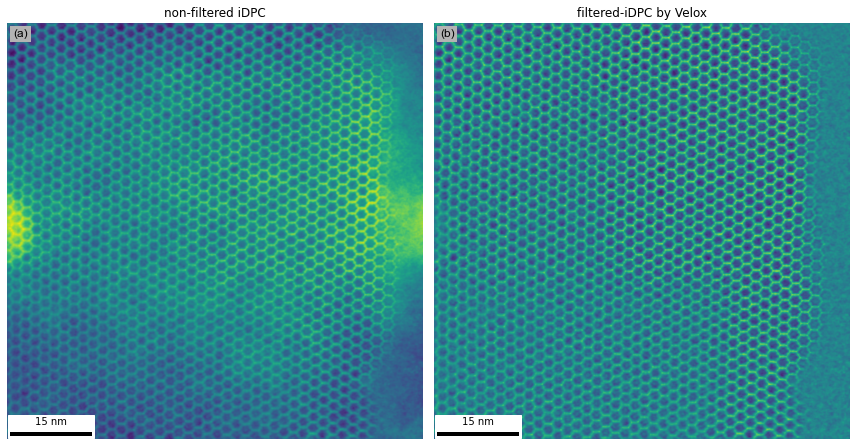

In [46]:
# extracting images from the dataset collected by velox software

iDPC_no_filtered = s[0]['iDPC']
iDPC_by_velox = s[0]['Unrecognized_image_signal']
# plot the images given by Velox
# if the "%matplotlib qt5" is activated, a popup window will appear where you can see images interactively.

ps.tools.plot_image([iDPC_no_filtered, iDPC_by_velox], properties= {
             'resolution': resolution,
              'unit': 'nm',
              'bar location':'',
             'image titles': ["non-filtered iDPC", "filtered-iDPC by Velox"],
             'figsize': 6,
              'cmap':'viridis',
              'dpi': 600,
              'image format':'.jpeg',
              'showing titles': True,
             'cropping image': [False, [500,1400], [256,256]],
             'saving image': False,   # if you want to save it, then 'True'
             'saving path':path_file+ "/iDPC_velox"  # choose the saving folder address and the name of this figure
              })

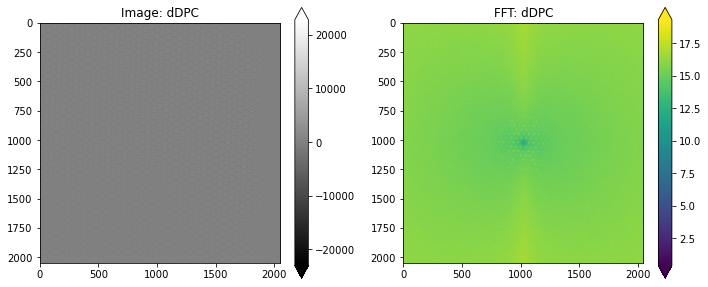

In [47]:
# another tool for showing the FFT

ps.tools.plot_fft(s[0]['dDPC'], names=['dDPC'])

In [48]:
# another tool for showing the FFT

ps.tools.show_FFT(s[0]['dDPC'], resolution, unit='nm')

interactive(children=(FloatSlider(value=5.0, description='sigma', max=10.0, min=3.0), IntSlider(value=50, desc…

In [49]:
# extracting segmented images from the dataset for the OBF reconstruction

dpcs, titles = ps.tools.extract_segmented_image(file, order_map={
          'DF4-A': 'A',
          'DF4-B': 'B',
          'DF4-C': 'C',
          'DF4-D': 'D'
        })

In [50]:
titles

['DF4-A', 'DF4-B', 'DF4-C', 'DF4-D']

In [51]:
CoMx = dpcs[0] - dpcs[2] # the rotation angle is 88 deg
CoMy = dpcs[1] - dpcs[3]

In [52]:
# cropping the 'CoMx' and 'CoMy' for time-saving in the sample-detector rotation finding

Cx = ps.tools.crop_matrix(CoMx, axis=(0,1), centre = [1024,1024], crop_size=[512,512])
Cy = ps.tools.crop_matrix(CoMy, axis=(0,1), centre= [1024,1024], crop_size=[512,512])

### 1. iDPC reconstruction using antisymmetric derivative integration

In [53]:
cal_idpc = ps.analysis.Noniterate_iDPCBuilder(CoMx, CoMy, epsilon = 3e-3)

In [54]:
# For our Themis Z machine, the rotation angle is about 88 (or 44) degrees, and it needs to flip (flip the directions of x- and y-axis)
# If you use A-C for CoMx and B-D for CoMy, then the angle is 88 degrees.

theta_1, flip_1 = cal_idpc.optimize_rotation(Cx, Cy, thetas = np.arange(-90, 90, 1), epsilon = 1e-3)

Calculating:   0%|          | 0/360 [00:00<?, ?iteration/s]

It is needed to preserve the intensity
Does it need to flip: True
The rotation angle is: 84.00 degrees


In [55]:
idpc = cal_idpc.run(theta_1, flip_1, expanding=True)

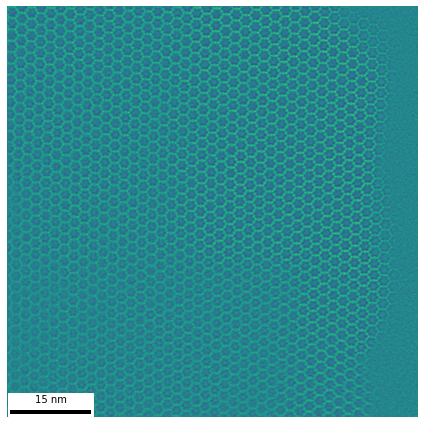

In [56]:
ps.tools.plot_image(idpc, properties= {
             'resolution': resolution,
              'unit': 'nm',
              'bar location':'', # the location of scale-bar in image
             'image titles': 'iDPC',
             'figsize':6,
              'cmap':'viridis',
              'dpi': 600, # the dpi for saving image 
              'image format':'.jpeg',
              'showing titles': False,
             'cropping image': [False, [1765,848], [128,128]], # you can amplify the small interested region of image
             'saving image': False,   # if you want to save it, then 'True'
             'saving path':path_file+ "1718/iDPC"  # choose the saving folder address and the name of this figure
              })

### 2. FM-STEM reconstruction

In [57]:
fm = ps.analysis.Noniterate_FMBuilder(CoMx, CoMy, epsilon=1e-3, mask=None)

In [58]:
#idpc_dft = dft_idpc.run(theta, flip, expanding=True)
t1, f1 = fm.optimize_rotation(Cx, Cy, thetas = np.arange(-90, 90, 1), epsilon = 1e-3)

Calculating:   0%|          | 0/360 [00:00<?, ?iteration/s]

It is needed to preserve the intensity
Does it need to flip: True
The rotation angle is: -6.00 degrees


In [59]:
fmstem = fm.run(t1, f1, expanding=True)

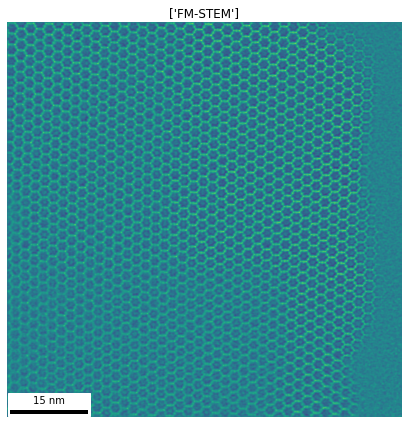

In [60]:
ps.tools.plot_image(fmstem, properties= {
             'resolution': resolution,
              'unit': 'nm',
              'bar location':'',
             'image titles': 'FM-STEM',
             'figsize':6,
              'cmap':'viridis',
              'dpi': 600,
              'image format':'.jpeg',
              'showing titles': True,
             'cropping image': [False, [1024,1024], [256,256]],
             'saving image': False,   # if you want to save it, then 'True'
             'saving path':path_file+ "1745/fmstem"  # choose the saving folder address and the name of this figure
              })

### Following codes are for OBF reconstruction
#### The key idea is to weight the intensity of segmented images in the Fourier space using a generated Foureir filters,
#### then adding the weighted intensity to create the OBF image.
#### Therefore, the noise contained in the segmented images will be included in the reconstructed OBF image.

In [61]:
# setting the residual aberrations


ab = {    'C1': -1,                          #defocus (over focus positive), a real value
              'A1': 0+1j*np.radians(0),     #Two-fold astigamastism
              'B2': 0,    #Axial coma, a complex, here using the result measured by Sherpa
              'A2': 0,         #Three-fold astigmatism
              'C3': 0,                                #Spherical aberration
              'A3': 0,          #Four-fold astigmatism
              'S3': 0,          #Axial star aberration
              'A4': 0}
print(ab)

{'C1': -1, 'A1': 0j, 'B2': 0, 'A2': 0, 'C3': 0, 'A3': 0, 'S3': 0, 'A4': 0}


In [62]:
wavelength = ps.analysis.wavelength_beam(300)

In [63]:
#describing the geometric planes of DF4 detectors

segments = np.array(([-45,45], [45,135], [135,225], [225,315]), dtype = np.float64)
print(segments)

[[-45.  45.]
 [ 45. 135.]
 [135. 225.]
 [225. 315.]]


In [65]:

parameters = {"sample thickness(nm)": 50,
             "wavelength(nm)": wavelength,
             "pixel size(nm)": resolution,
              "dose rate(e-Å-2)": 1,
             "collection angles(rad)": [0.006, 0.034], # the maximum collection angle should be larger than twice of semi-convergence angle
             "semi_convergence angle(rad)": 0.015,
             "pixelnumber of filters": dpcs[0].shape[0]/8, #controlling the pixel size of the filter for time-saving
             "virtual grids in one segment detector": 20}

In [66]:
# you also can try "phase_filters_GPU", which requires a GPU and CUDA in your computer.

phase_filters, norm = ps.analysis.phase_filters_CPU(ab, segments, parameters, slices=1, process=True)

The specimen is treated as 1 slices!



Building:   0%|           [ time left: ? ]

There will be 1 slices for computation!



Building:   0%|           [ time left: ? ]

The whole process takes 11 seconds.
--- 44 seconds left!
There will be 1 slices for computation!



Building:   0%|           [ time left: ? ]

The whole process takes 11 seconds.
--- 33 seconds left!
There will be 1 slices for computation!



Building:   0%|           [ time left: ? ]

The whole process takes 11 seconds.
--- 22 seconds left!
There will be 1 slices for computation!



Building:   0%|           [ time left: ? ]

The whole process takes 11 seconds.
--- 11 seconds left!
The whole process takes 42 seconds.


In [67]:
built_WPO = []
for ft in phase_filters:
    built_WPO.append(ft/norm)

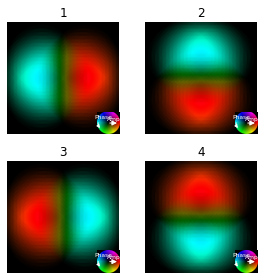

In [68]:
ps.tools.plot_vector_image(built_WPO, title=['1', '2', '3', '4'], imgsize = 4, storing = [False, 'path_save'])

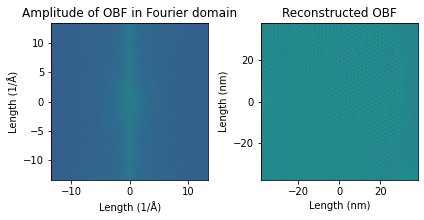

In [69]:
Builder= ps.analysis.OBFBuilder(dpcs, phase_filters, parameters, mask=None)
OBF_img, OBF_Q = Builder.reconstruct_OBF(upsampling=0, plot=True)

### evaluate the defocus value in the Fourier filter creation
#### the defocus and the 2-fold astigmastism play significant roles in the reconstruction

In [40]:
banks = []

In [60]:
for i in range(-5, 0, 1):
    aberrations = { 'C1': i,                                   
            'A1': 0 + 1j*np.radians(0),    
                 
         }
    # as this procedure takes much time, I suggest that a small "pixelnumber of filters" in "parameters" is given.
    phase_filters, norm = ps.analysis.phase_filters_GPU(aberrations, segments, parameters, slices=1, process=True)
    Builder= ps.analysis.OBFBuilder(dpcs, phase_filters, parameters, mask=None)
    OBF_img, OBF_Q = Builder.reconstruct_OBF(upsampling=0, plot=False)
    banks.append(OBF_img)
    print(i, np.std(OBF_img)) # the higher of np.std(image), the better of quality of reconstructed OBF

Building:   0%|           [ time left: ? ]

--- 4 seconds left!
The whole process takes 15 seconds.
10 40.67714713296737


Building:   0%|           [ time left: ? ]

--- 4 seconds left!
The whole process takes 15 seconds.
12 40.91918221889671


Building:   0%|           [ time left: ? ]

--- 4 seconds left!
The whole process takes 15 seconds.
14 40.984162050459645


Building:   0%|           [ time left: ? ]

--- 4 seconds left!
The whole process takes 15 seconds.
16 41.147024688570156


Building:   0%|           [ time left: ? ]

--- 4 seconds left!
The whole process takes 15 seconds.
18 37.08336389655259


### Background noises in the raw segmented images are intrinsic in detector, which the noise will be inherited and presented in the reconstructed OBF image.
### Following procedures are helpful to rid noises from the Fourier domain.

In [81]:
img_abs, _= ps.EMFilters.abs_filter(OBF_img, delta=2, lowpass_cutoff = 0.4)


In [67]:
img_wiener,_ = ps.EMFilters.wiener_filter(OBF_img, lowpass_cutoff = 0.3*2)


In [70]:
denoised, _ = ps.EMFilters.nonlinear_filter(OBF_img, space ='real', N=50, mode='wiener', delta=5, 
                                            lowpass_cutoff=0.4, lowpass = False, lowpass_order=4)

Building:   0%|           [ time left: ? ]

In [129]:
denoised_iDPC, _ = ps.EMFilters.nonlinear_filter(idpc, space ='real', N=50, mode='wiener', delta=5, 
                                            lowpass_cutoff=0.4, lowpass = True, lowpass_order=4)

Building:   0%|           [ time left: ? ]

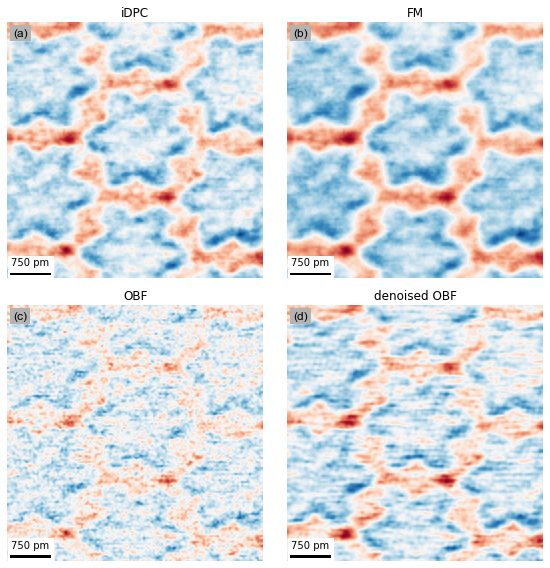

In [72]:
image_cubes =  [idpc, fmstem, OBF_img, denoised]

ps.tools.plot_image(image_cubes, properties= {
             'resolution': resolution,
              'unit': 'nm',
              'bar location':'',
             'image titles': ['iDPC','FM', 'OBF', 'denoised OBF'],
             'figsize':4,
              'cmap':'RdBu_r',
              'dpi': 600,
              'image format':'.jpeg',
              'showing titles': True,
             'cropping image': [True, [1580,90], [128,128]],
             'saving image': False,   # if you want to save it, then 'True'
             'saving path':path_file+ "1745/radial_average_remove3"  # choose the saving folder address and the name of this figure
              })

In [56]:
import h5py

In [57]:

data = h5py.File(f"{path_file}/results.h5", 'w')
reconstruct = data.create_group(str(resolution))
reconstruct.create_dataset("OBF", data= OBF_img)
reconstruct.create_dataset("iDPC", data= idpc)
reconstruct.create_dataset("FM", data= fmstem)
data.close()